# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [1]:
% matplotlib inline
% pprint off
import scipy.misc
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from skimage import io
from skimage.color import rgb2gray
### import the libraries you think its necessary for your task 

Pretty printing has been turned OFF


In [2]:
def plot_cdf(image):
    width, height = plt.rcParams['figure.figsize']
    img_cdf, bins = exposure.cumulative_distribution(image)
    fig , (ax0, ax1) = plt.subplots(ncols=2,figsize=(2 * width, height))
    ax1.plot(bins, img_cdf, 'r')
    ax1 = ax1.twinx()
    ax1.hist(image.flatten(),256,normed=1)
    ax0.imshow(image,cmap='gray')

In [35]:
def imshow_with_histogram(image):
    width, height = plt.rcParams['figure.figsize']
    fig, (ax_image, ax_hist) = plt.subplots(ncols=2, figsize=(2*width, height))
    ax_image.imshow(image, cmap='gray')
    ax_hist.hist(image.flatten(),100,histtype = 'barstacked')

In [36]:
path = './images/'
Image_name ='satellite.jpg'
satellite = io.imread(path.__add__(Image_name))

### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [34]:
import scipy.misc
from skimage import img_as_ubyte


def cont_str(Image):
    im_max = Image.max()
    im_min = Image.min()
    I_im = Image.astype(float)
    im2 = 255*(I_im-im_min)/(im_max-im_min)
    im3 = scipy.misc.toimage(im2)
    return img_as_ubyte(im3)


**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

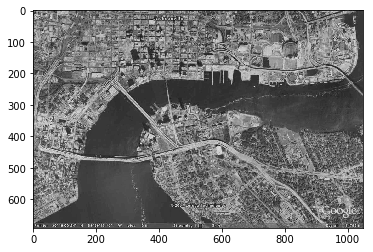

In [6]:
satellite_gray = rgb2gray(satellite)
im = cont_str(satellite_gray);
plt.imshow(im,cmap='gray')

### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [39]:
import numpy as np

def hist_eq(im,max_int, min_int):
    """ Histogram equalization of a grayscale image. """
    # get image histogram
    nbr_bins = int(max_int - min_int)
    imhist,bins = np.histogram(im.flatten(),nbr_bins, normed=False)
    cdf = imhist.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize
    # use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf) #linear interpolation
    return im2.reshape(im.shape) , cdf

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

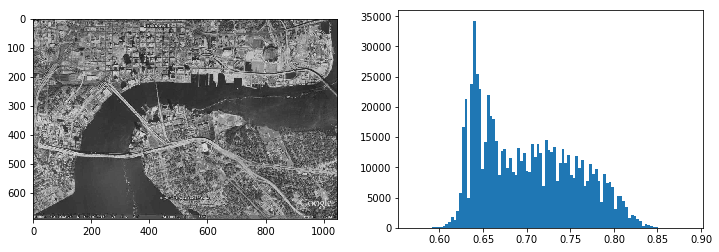

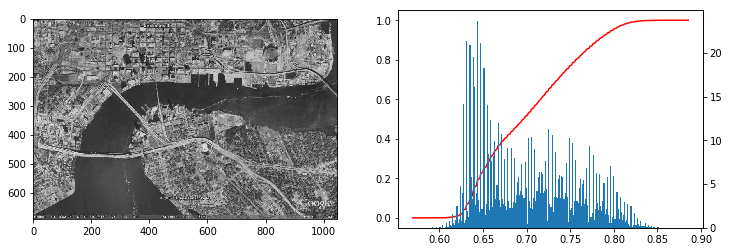

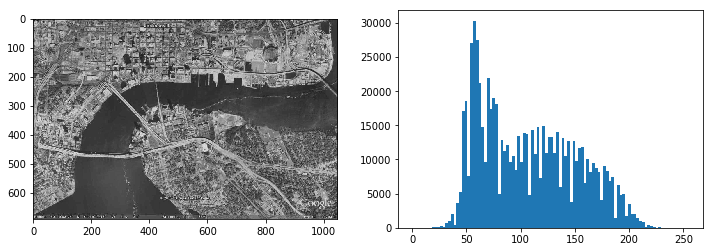

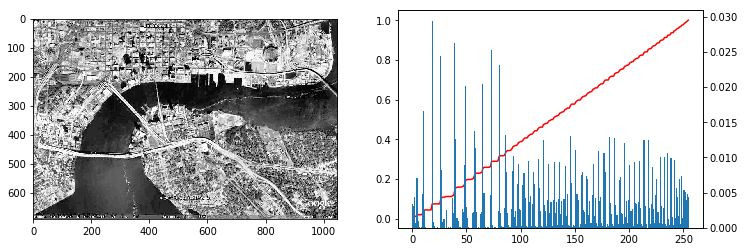

In [40]:
from skimage import exposure
histeq_Image , cdf_eq = hist_eq(satellite_gray,255,0)
imshow_with_histogram(satellite_gray)
plot_cdf(satellite_gray)
imshow_with_histogram(cont_str(satellite_gray))
plot_cdf(histeq_Image)

**Show the transformed image and its histogram**

### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

Here we want to convert the image so that it has a particular histogram that can be arbitrarily specified. Such a mapping function can be found in three steps:

    Equalize the histogram of the input image
    Equalize the specified histogram
    Relate the two equalized histograms by using the CDF function
    

In [41]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [42]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match  

**Creating a manual pdf following a gaussian distribution**

/home/eljazri/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


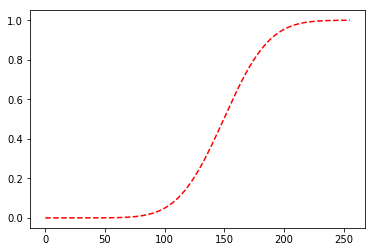

In [77]:
from scipy.stats import norm

satellite_gray_8 = img_as_ubyte(satellite_gray)

max_img = satellite_gray_8.max()

min_img = satellite_gray_8.min()
x = np.arange(256)

pdf_to_fit = norm.pdf(x, 150, 30)
cdf_pdf = np.cumsum(pdf_to_fit)
plt.plot(x,cdf_pdf,'r--')


**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

/home/eljazri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  


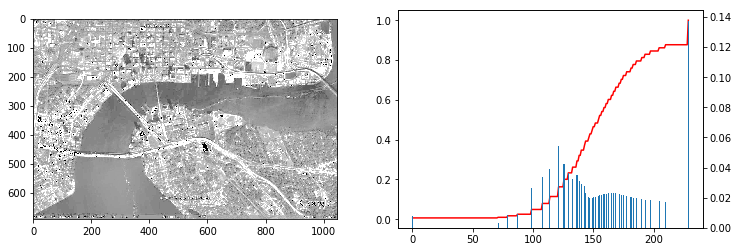

In [78]:
ImageIn, pdf2 = hist_eq(satellite_gray_8,min_img,max_img)

Matched_img  = hist_match(ImageIn,pdf_to_fit, min_img, max_img)

plot_cdf(Matched_img)

#the amount of constant in the image affected by the pdf distribution

### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


Log transformation is used to enhance pixel intensities that are
otherwise missed becuse to a wide range of intensity values or lost at the
expense of high intensity values. If the intensities in the image range
from $[0, L − 1]$ then the log transformation at $(i, j)$ is given by $$t(i, j) = k log(1 + I(i, j))$$

$k = \frac{L-1}{log(1+|I_{max}|)}$ and $I_{max}$ is maximum magnitude value and $I(i, j)$



the log trans-
formation also maps a small range of dark or low intensity pixel values
in the input image to a wide range of intensities in the output im-
age, while a wide range of bright or high intensity pixel values in the
input image get mapped to narrow range of high intensities in the out-
put image.

gamma transform, is used
to enhance the quality of the image. The power transformation at $(i, j)$
is given by
$$t(i, j) = k I(i, j)^γ$$
where $k$ and $γ$ are positive constants and $I$ is the intensity value of the
pixel in the input image at $(i, j)$. In most cases k = 1
When $γ < 1$, a narrow range
of dark or low intensity pixel values in the input image get mapped
to a wide range of intensities in the output image, while a wide range
of bright or high intensity pixel values in the input image get mapped
to a narrow range of high intensities in the output image. The effect
from values of $γ > 1$ is opposite that of values $γ < 1$. Considering that
the intensity range is between $[0, 1]$.


** Explain how sigmoid function enhances the image **

The sigmoid function is non-linear mapping from the input image to the output image to increasing the contrast means making the dark regions darker and bright regions brighter